In [3]:
import qutip as qt 
import numpy as np 
import matplotlib.pyplot as plt 

In [9]:
def mackey_glass_generator(n_points=2000, dt=1.0):

    # Parameters from the paper (standard values)
    beta = 0.2
    gamma = 0.1
    tau = 17
    n = 10
    
    # We need an initial history for the delay differential equation
    history_len = int(tau / dt)
    # Start with some initial values
    f = np.zeros(n_points + history_len)
    f[:history_len] = 0.9 + 0.1 * np.random.rand(history_len)

    # Iteratively generate the series
    for k in range(history_len, n_points + history_len):
        f_tau = f[k - history_len]
        df_dt = beta * f_tau / (1 + f_tau**n) - gamma * f[k-1]
        f[k] = f[k-1] + dt * df_dt
        
    # Discard the initial history part
    return f[history_len:]

In [10]:

N_photons = 7         # Max photons in cavity (Fock space truncation)
wc = 40.0             # Cavity frequency
wa = 20.0             # Atom frequency
g = 30.0              # Coupling strength
kappa = 10.0          # Base decay rate
epsilon = 20.0        # Driving strength of the input signal

In [11]:
# We need to define our operators in the combined (tensor) space of the
# cavity and the atom.

# Identity operators for each subspace
iden_cavity = qt.qeye(N_photons)
iden_atom = qt.qeye(2)

# Annihilation operator for the cavity ('c' in the paper)
# qt.destroy(N) creates the operator for a system with N levels.
# We tensor it with the atom's identity to make it live in the full space.
c = qt.tensor(qt.destroy(N_photons), iden_atom)

# Lowering operator for the atom ('σ⁻' in the paper)
# We tensor it with the cavity's identity.
sm = qt.tensor(iden_cavity, qt.sigmam())

In [12]:
# The Hamiltonian has a time-independent part (H0) and a time-dependent
# part (H1) which is driven by our input signal f(t).

# Time-Independent Hamiltonian (H0 from Eq. 1)
# H0 = wc*c†c + wa*σz/2 + g*(c†σ⁻ + cσ⁺)
# Note: c.dag() is the creation operator c†, sm.dag() is σ⁺.
# The Pauli-Z operator σz is sm.dag()*sm - sm*sm.dag() or just qt.sigmaz()
sz = qt.tensor(iden_cavity, qt.sigmaz())
H0 = wc * c.dag() * c + 0.5 * wa * sz + g * (c.dag() * sm + c * sm.dag())

# Time-Dependent (Input) Hamiltonian (H1 from Eq. 2)
# H1(t) = i*ε*f(t)*(c - c†)
# QuTiP handles the f(t) part separately. We just define the operator part.
H1_operator = epsilon * 1j * (c - c.dag())

In [13]:
# The system needs to dissipate energy to forget old inputs. This is done
# with "collapse operators" (c_ops) for the master equation solver.
# The paper uses a scaled decay rate. For N_atom=1:
num_atoms = 1
scaled_kappa = kappa / (2 * num_atoms + 2)
c_ops = [
    np.sqrt(scaled_kappa) * c,   # Cavity photon loss
    np.sqrt(scaled_kappa) * sm   # Atomic spontaneous emission
]



In [14]:
print("Generating Mackey-Glass data...")
# --- Task Parameters ---
warmup_len = 200      # Time for the reservoir to settle before training
train_len = 1000      # Number of timesteps for training
test_len = 500        # Number of timesteps for testing
total_len = warmup_len + train_len + test_len
delay = 20            # The prediction horizon (predict f(t+20))

# Generate the input signal f(t)
input_signal = mackey_glass_generator(n_points=total_len + delay)
times = np.arange(total_len)

print("Starting quantum simulation ")
# --- Prepare for the Solver ---
# Initial state: cavity vacuum and atom in the ground state.
psi0 = qt.tensor(qt.basis(N_photons, 0), qt.basis(2, 0))

# Readout Operators: These are the values we "measure" from the reservoir.
# (Eqs. 3 and 4 in the paper)
e_ops = [
    c + c.dag(),           # Cavity Quadrature <Q>
    1j * (c.dag() - c),    # Cavity Quadrature <P>
    qt.tensor(iden_cavity, qt.sigmax()), # Atom <σx>
    qt.tensor(iden_cavity, qt.sigmay())  # Atom <σy>
]

# The full time-dependent Hamiltonian for the solver
# Format: [H0, [H1_operator, input_signal_as_array]]
H = [H0, [H1_operator, input_signal[:total_len]]]

# --- Run the Solver! ---
# This simulates the physics and computes our readouts at each time step.
result = qt.mesolve(H, psi0, times, c_ops, e_ops)
print("Simulation finished.")

Generating Mackey-Glass data...
Starting quantum simulation 


c:\Users\Priyanshi\anaconda3\envs\qisk\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Simulation finished.


Training complete. Readout weights W found.

Testing Performance: NRMSE = 0.0761


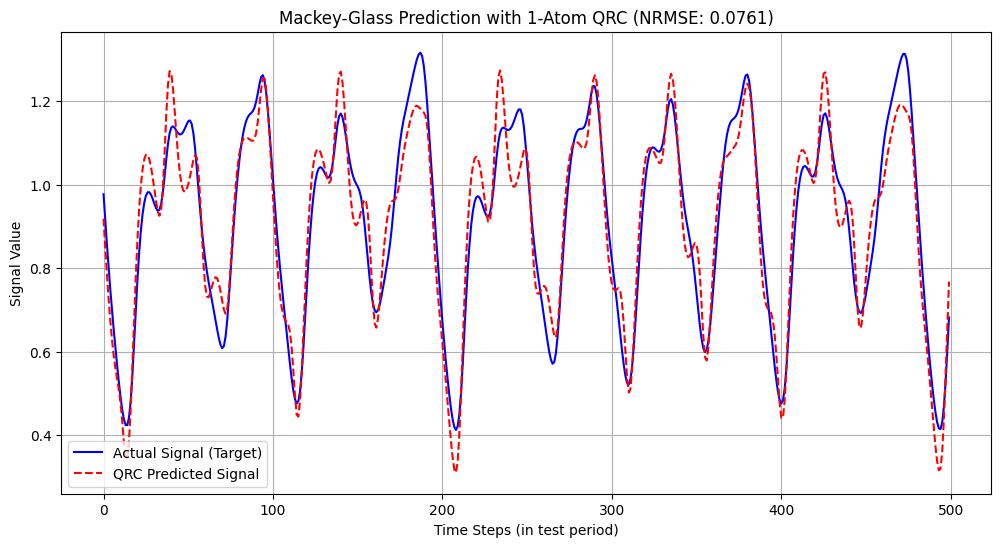

In [15]:
# Now we use classical machine learning (linear regression) to map the
# reservoir's readouts to the target output.

# --- Prepare the Training Data ---
# The readouts from the reservoir (the "features" for our ML model)
# We transpose result.expect so each row is a time step and each column a feature.
readouts = np.array(result.expect).T
X_raw = readouts[warmup_len : warmup_len + train_len]

# Add a constant bias term to the features, as described in the paper.
# This allows the linear model to have a non-zero intercept.
X_train = np.hstack([np.ones((train_len, 1)), X_raw])

# The target output: the Mackey-Glass signal, delayed by 'delay' steps.
Y_train = input_signal[warmup_len + delay : warmup_len + train_len + delay]

# --- Solve for the Optimal Weights (W) ---
# We use the Moore-Penrose pseudoinverse, as per Appendix B.
# This finds the weights W that minimize the squared error between
# X_train @ W and Y_train.
W = np.linalg.pinv(X_train) @ Y_train
print("Training complete. Readout weights W found.")

# We use the trained weights W on unseen data to make predictions and


X_test_raw = readouts[warmup_len + train_len : total_len]
X_test = np.hstack([np.ones((test_len, 1)), X_test_raw])

# The "ground truth" for the test period.
Y_test_actual = input_signal[warmup_len + train_len + delay : total_len + delay]

# --- Make the Prediction ---
Y_predicted = X_test @ W

# --- Evaluate Performance using NRMSE (Normalized Root Mean Square Error) ---
# This is the metric used in the paper (Eq. 8).
nrmse = np.sqrt(np.mean((Y_predicted - Y_test_actual)**2)) / (Y_test_actual.max() - Y_test_actual.min())
print(f"\nTesting Performance: NRMSE = {nrmse:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(Y_test_actual, 'b', label='Actual Signal (Target)')
plt.plot(Y_predicted, 'r--', label='QRC Predicted Signal')
plt.legend()
plt.title(f'Mackey-Glass Prediction with 1-Atom QRC (NRMSE: {nrmse:.4f})')
plt.xlabel('Time Steps (in test period)')
plt.ylabel('Signal Value')
plt.grid(True)
plt.show()